# Objective of the Exploration
* Provide summary statistics
    * Descriptive Statistics
* Determine operating cost of individual power plants
* Show how fuel costs impact the viability of the different generation sources
* Highlight the competitiveness of renewable electricity
* Show how the generation mix of different utilities evolved overtime

In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('raw_data.csv')
df.head(5)

,record_id,utility_id_ferc1,report_year,plant_name_ferc1,fuel_type_code_pudl,fuel_unit,fuel_qty_burned,fuel_mmbtu_per_unit,fuel_cost_per_unit_burned,fuel_cost_per_unit_delivered,fuel_cost_per_mmbtu
0,f1_fuel_1994_12_1_0_7,1,1994,rockport,coal,ton,5377489.0,16.590,18.59,18.53,1.121
1,f1_fuel_1994_12_1_0_10,1,1994,rockport total plant,coal,ton,10486945.0,16.592,18.58,18.53,1.120
2,f1_fuel_1994_12_2_0_1,2,1994,gorgas,coal,ton,2978683.0,24.130,39.72,38.12,1.650
3,f1_fuel_1994_12_2_0_7,2,1994,barry,coal,ton,3739484.0,23.950,47.21,45.99,1.970
4,f1_fuel_1994_12_2_0_10,2,1994,chickasaw,gas,mcf,40533.0,1.000,2.77,2.77,2.570


In [3]:
df.columns

Index(['record_id', 'utility_id_ferc1', 'report_year', 'plant_name_ferc1',
       'fuel_type_code_pudl', 'fuel_unit', 'fuel_qty_burned',
       'fuel_mmbtu_per_unit', 'fuel_cost_per_unit_burned',
       'fuel_cost_per_unit_delivered', 'fuel_cost_per_mmbtu'],
      dtype='object')

In [4]:
# rename columns
df.columns = ['record_id', 'utility_id', 'year', 'plant_name',
              'type', 'unit', 'qty_burned', 'mmbtu_PU',
              'cost_PU_burned', 'cost_PU_delivered', 'cost_per_mmbtu']

In [5]:
# compute values for summary statistcs
a = len(df)
b = df['utility_id'].nunique()
c = '{}-{}'.format(df['year'].min(), df['year'].max())
d = df['plant_name'].nunique()
e = df['type'].nunique()
f = df['unit'].nunique()

In [6]:
summ = {'Item': ['Records', 'Utilities', 'Period', 'Plants', 'Sources', 'Units'], \
       'Value': [a, b, c, d, e, f]}
sum_table = pd.DataFrame(summ)
sum_table.set_index('Item', inplace=True)
sum_table.transpose()

Item,Records,Utilities,Period,Plants,Sources,Units
Value,29523,185,1994-2018,2315,6,9


This simple record summary shows how much investment is made on electricity across the United States. 2307 plants accross the country is a rather large number in a bid to provide stable and improved energy for household and organisations.

## Data Cleaning

In [7]:
# check data types
df.dtypes

record_id             object
utility_id             int64
year                   int64
plant_name            object
type                  object
unit                  object
qty_burned           float64
mmbtu_PU             float64
cost_PU_burned       float64
cost_PU_delivered    float64
cost_per_mmbtu       float64
dtype: object

Every column looks well formatted except year formatted as int64. But since it only contains year, it will be left as is.

In [8]:
# check for duplicates
df.duplicated().any()

False

In [9]:
# check for missing values
df.isnull().sum()

record_id              0
utility_id             0
year                   0
plant_name             0
type                   0
unit                 180
qty_burned             0
mmbtu_PU               0
cost_PU_burned         0
cost_PU_delivered      0
cost_per_mmbtu         0
dtype: int64

In [57]:
print('There\'s {}{} missing values in the fuel unit column'.format((df['unit'].isnull().sum() / len(df)).round(3) * 100, '%'))

There's 0.6% missing values in the fuel unit column


In [50]:
df['unit'].unique()

array(['ton', 'mcf', 'kgU', 'bbl', 'gramsU', nan, 'mwdth', 'mmbtu',
       'mwhth', 'gal'], dtype=object)

Only unit column has missing values. Because the missing values are only 0.6% of the lenght of the records, and since it's relating to fuel type, the missing values will be filled based on most occured (mode) unit for each fuel type.

In [11]:
df['unit'] = df.groupby('type')['unit'].apply(lambda x : x.fillna(x.value_counts().index[0]))

In [12]:
# comfirm imputation
df['unit'].isnull().sum()

0

Round all figures to two decimal places

In [13]:
cols = ['mmbtu_PU', 'cost_PU_burned', 'cost_PU_delivered',
       'cost_per_mmbtu']

In [14]:
df[cols] = df[cols].apply(lambda x : x.round(2))

In [15]:
df.head(2)

,record_id,utility_id,year,plant_name,type,unit,qty_burned,mmbtu_PU,cost_PU_burned,cost_PU_delivered,cost_per_mmbtu
0,f1_fuel_1994_12_1_0_7,1,1994,rockport,coal,ton,5377489.0,16.59,18.59,18.53,1.12
1,f1_fuel_1994_12_1_0_10,1,1994,rockport total plant,coal,ton,10486945.0,16.59,18.58,18.53,1.12


## Feature Engineering
From exloration and understanding of the dataset, it was discovered that fuel cost per unit burned is already in mmbtu because fuel cost per mmbtu multiplied by fuel mmbtu per unit is equals to fuel cost per unit burned with few approximation lapses. Therefore, fuel cost per unit burned is the fuel cost in mmbtu. <br>
Based on the above, three new features will be created.
* Total Energy will be created by multiplying quantity burned by fuel mmbtu per unit.
* Total Energy/Fuel cost will be created by multiplying total energy by fuel cost per mmbtu
* Electricity/kWh will be created by dividing total energy by 3412.

In [16]:
df['total_energy'] = (df['qty_burned'] * df['mmbtu_PU']).round(2)
df['total_energy/fuel_cost'] = (df['total_energy'] * df['cost_per_mmbtu']).round(2)
df['kWh'] = (df['total_energy'] / 3412).round(2)

## Summary Statistics

In [17]:
# check desccriptive statistics
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
utility_id,29523.0,1.186018e+02,7.417835e+01,1.00,55.000,122.00,1.760000e+02,5.140000e+02
year,29523.0,2.005806e+03,7.025483e+00,1994.00,2000.000,2006.00,2.012000e+03,2.018000e+03
qty_burned,29523.0,2.622119e+06,9.118004e+06,1.00,13817.000,253322.00,1.424034e+06,5.558942e+08
mmbtu_PU,29523.0,8.491992e+00,1.060027e+01,0.00,1.020,5.76,1.701000e+01,3.412600e+02
cost_PU_burned,29523.0,2.086490e+02,2.854490e+03,-276.08,5.205,26.00,4.711000e+01,1.393580e+05
cost_PU_delivered,29523.0,9.175704e+02,6.877593e+04,-874.94,3.780,17.37,4.213500e+01,7.964521e+06
cost_per_mmbtu,29523.0,1.930434e+01,2.091541e+03,-41.50,1.940,4.13,7.745000e+00,3.592780e+05
total_energy,29523.0,1.444295e+07,1.024990e+08,0.00,33861.870,468917.00,1.248096e+07,1.284672e+10
total_energy/fuel_cost,29523.0,2.999413e+07,1.505306e+08,-19526.58,244489.150,2722800.08,2.682217e+07,1.888467e+10
kWh,29523.0,4.232986e+03,3.004073e+04,0.00,9.925,137.43,3.657960e+03,3.765157e+06


In [18]:
# import visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt
from jupyterthemes import jtplot
import matplotlib.dates as mdates

In [19]:
cols = ['qty_burned', 'mmbtu_PU', 'cost_PU_burned', 'cost_PU_delivered', 'cost_per_mmbtu', 'total_energy', 'total_energy/fuel_cost', 'kWh']

<Figure size 432x288 with 0 Axes>

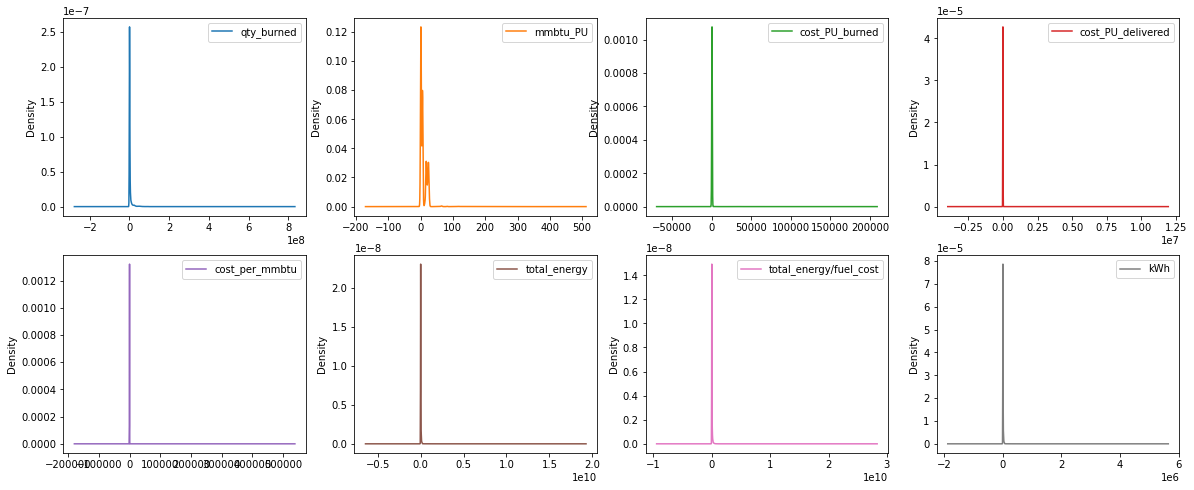

In [20]:
fig = plt.figure()
df[cols].plot(kind='kde', subplots=True, layout=(2,4), sharex=False, sharey=False, figsize=(20,8))
plt.show()

The distribution plots above show that the dataset is skewed to the right. Since missing values were only found in the categorical variable column, this means that there are outliers in the dataset.

In [21]:
# replace outliers with median value as mean value is affected by outliers
Q1 = df[cols].quantile(0.25)
Q3 = df[cols].quantile(0.75)
IQR = Q3 - Q1 * 1.5
df[cols] = np.where(((df[cols] > Q3 + IQR) | (df[cols] < Q1 - IQR)), df[cols].median(), df[cols])

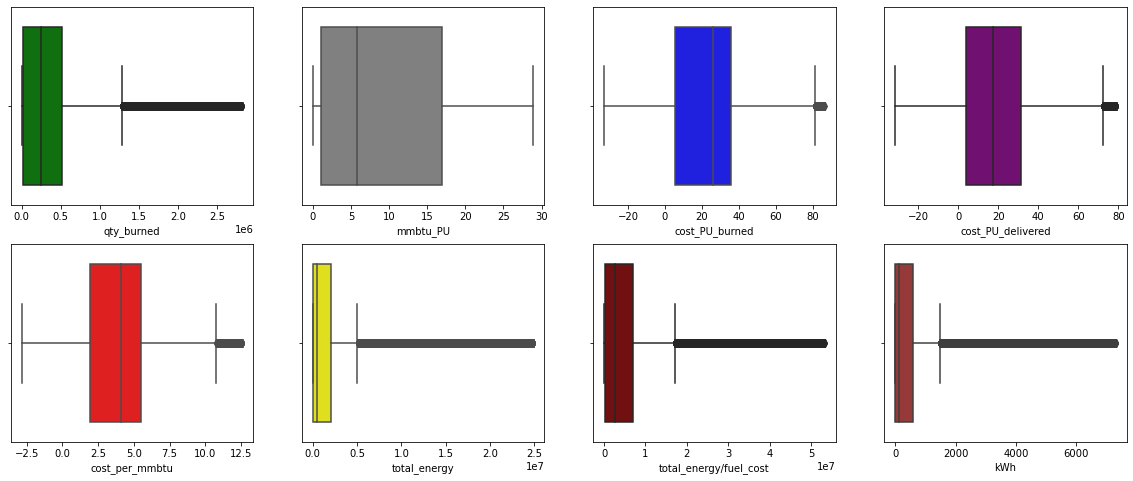

In [22]:
# show boxplot after removing outliers
fig = plt.figure(figsize=(20,8))
ax0 = fig.add_subplot(2,4,1)
ax1 = fig.add_subplot(2,4,2)
ax2 = fig.add_subplot(2,4,3)
ax3 = fig.add_subplot(2,4,4)
ax4 = fig.add_subplot(2,4,5)
ax5 = fig.add_subplot(2,4,6)
ax6 = fig.add_subplot(2,4,7)
ax7 = fig.add_subplot(2,4,8)
sns.boxplot(df[cols[0]], ax=ax0, color='g')
sns.boxplot(df[cols[1]], ax=ax1, color='grey')
sns.boxplot(df[cols[2]], ax=ax2, color='b')
sns.boxplot(df[cols[3]], ax=ax3, color='purple')
sns.boxplot(df[cols[4]], ax=ax4, color='red')
sns.boxplot(df[cols[5]], ax=ax5, color='yellow')
sns.boxplot(df[cols[6]], ax=ax6, color='maroon')
sns.boxplot(df[cols[7]], ax=ax7, color='brown')
plt.show()

Seeing the visualzation above, it becomes clear that the most used source of electricity from 1994 to 2018 used gas, followed by coal. Save the _other_ category, the least generated is waste.

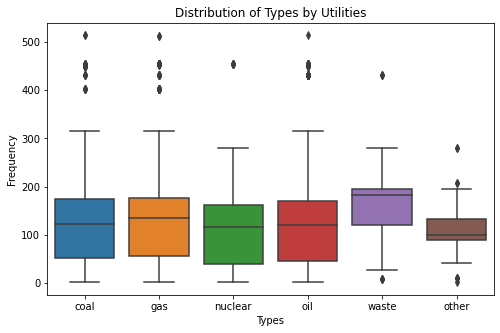

In [23]:
fig, ax = plt.subplots(figsize=(8,5))
ax = sns.boxplot(x='type', y='utility_id', data=df)
ax.set_title('Distribution of Types by Utilities')
ax.set_xlabel('Types')
ax.set_ylabel('Frequency')
plt.show()

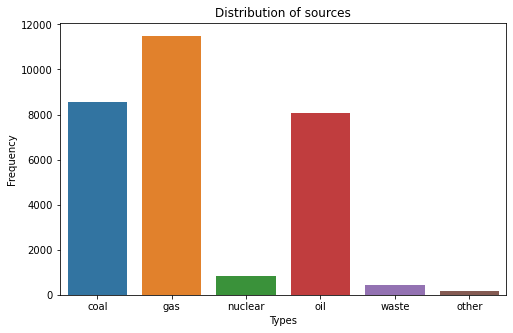

In [24]:
fig, ax = plt.subplots(figsize=(8,5))
ax = sns.countplot(df['type'])
ax.set_title('Distribution of sources')
ax.set_xlabel('Types')
ax.set_ylabel('Frequency')
plt.show()

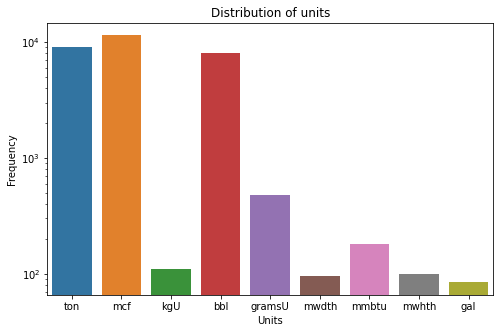

In [25]:
fig, ax = plt.subplots(figsize=(8,5))
ax = sns.countplot(df['unit'])
ax.set_title('Distribution of units')
ax.set_xlabel('Units')
ax.set_ylabel('Frequency')
ax.set_yscale('log')
plt.show()

In [28]:
jtplot.style(theme='monokai', context='notebook', fscale=1.5, spines=True)

In [29]:
mix = pd.concat([gen.loc[gen['type'] == 'coal', ['year', 'total_energy']].set_index('year'),
                gen.loc[gen['type'] == 'gas', ['year', 'total_energy']].set_index('year'),
                gen.loc[gen['type'] == 'nuclear', ['year', 'total_energy']].set_index('year'),
                gen.loc[gen['type'] == 'oil', ['year', 'total_energy']].set_index('year'),
                gen.loc[gen['type'] == 'waste', ['year', 'total_energy']].set_index('year'),
                gen.loc[gen['type'] == 'other', ['year', 'total_energy']].set_index('year')], join='outer', axis=1)
mix.columns = ['coal', 'gas', 'nuclear', 'oil', 'waste', 'other']

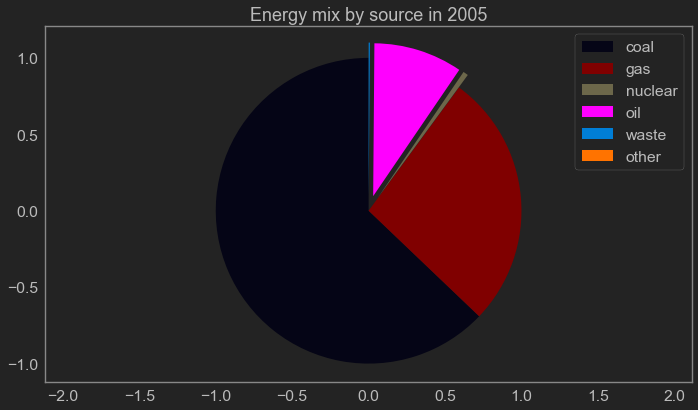

In [134]:
color = ['#050516', 'maroon', '#6C674A', 'magenta', '#007ED6', '#FF7300']
mix_chart = mix.loc[2005]
mix_chart.plot(kind='pie',
             colors = color,
             figsize=(10,6),
             startangle=(90),
             pctdistance=0.6,
             explode=[0,0,0.1,0.1,0.1,0.1], frame=True,
             autopct=None, labels=None, legend=True),
plt.title('Energy mix by source in {}'.format(mix_chart.name))
plt.ylabel('')
plt.axis('equal')
plt.tight_layout()
plt.show()

## Operational Cost
Based on the information available in the dataset, to dermine operational cost for each plant, fuel cost will be added to delivery cost. Delivery cost will be calculated by multiplying fuel_cost_per_unit_delivered by qty_burned.

In [32]:
df['delivery_cost'] = df['qty_burned'] * df['cost_PU_delivered']
df['operational_cost'] = df['total_energy/fuel_cost'] + df['delivery_cost']

Now that operational cost has been determined. The dataframe will be grouped by plant name and operational cost used as the value.

In [52]:
plant_cost = df.groupby(['year', 'plant_name'], as_index=False).agg({'operational_cost':'sum'})
plant_cost.head()

,year,plant_name,operational_cost
0,1994,(1)sta98,231374.09
1,1994,(2) scriba sta. 99,136053.83
2,1994,(n)(t)moss landing,2722800.08
3,1994,* campbell 3,71393488.44
4,1994,* decordova,4375976.85


In [34]:
plant_cost['plant_name'].nunique()

2315

### Showing how fuel costs impact the viability of the different generation sources
The objective here is to match the cost of different sources against their demand and show how demand respond to fuel cost. A good indicator for demand in this context would be quantity burned, and it would be matched with fuel cost per unit. However, it would be more appropriate to use the fuel market price per unit.

In [102]:
impact = df.groupby(['year', 'type'], as_index=False).agg({'cost_PU_burned':'mean', 'qty_burned':'mean'})

In [103]:
impact.head()

,year,type,cost_PU_burned,qty_burned
0,1994,coal,31.546505,792678.966316
1,1994,gas,4.113101,287852.874743
2,1994,nuclear,24.510141,559563.661972
3,1994,oil,33.352289,8853.710843
4,1994,other,9.725833,424538.166667


Having grouped the dataframe, gas will be used as a case.

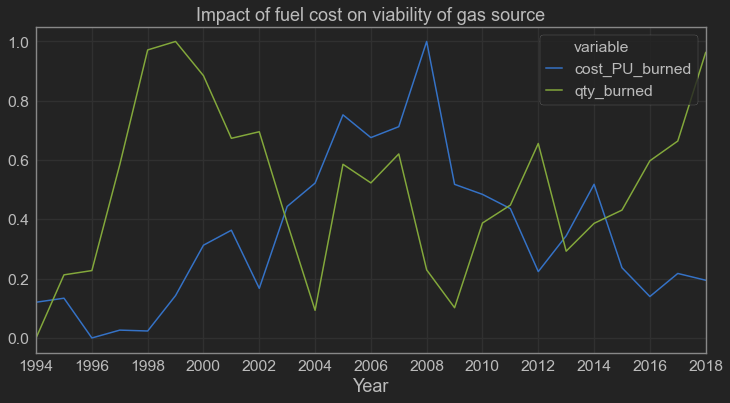

In [129]:
gas = impact.loc[impact['type'] == 'gas', ['year', 'cost_PU_burned', 'qty_burned']]
from sklearn.preprocessing import MinMaxScaler
gas[['cost_PU_burned', 'qty_burned']] = MinMaxScaler().fit_transform(gas[['cost_PU_burned', 'qty_burned']])

gas_melt = pd.melt(gas, id_vars='year', value_vars=['cost_PU_burned', 'qty_burned'])

fig, ax = plt.subplots(figsize=(12,6))
ax = sns.lineplot(x='year', y='value', hue='variable', data=gas_melt)
ax.set_title('Impact of fuel cost on viability of gas source')
ax.set_xlabel('Year')
ax.set_ylabel('')
ax.set_xlim(1994,2018)
plt.xticks(np.arange(1994, 2018+1, 2))
ax.legend(loc='upper right', handlelength=1)
plt.show()

Without having to check the correlation of these two variables, the line plot shows that fuel cost has a negative impact on the viability of gas as a generation source. As it is shown in the graph the quantity of gas demanded for (quantity burned) reduces as the unit price increases.

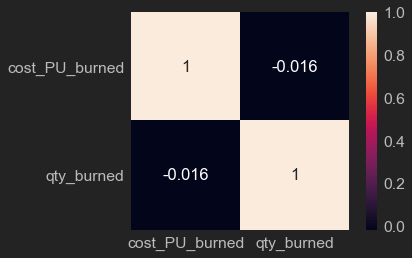

In [112]:
fig, ax = plt.subplots(figsize=(6,4))
ax = sns.heatmap(df[['cost_PU_burned', 'qty_burned']].corr(), annot=True, square=True)
plt.show()

This correlation map further butresses what is shown in the previous line plot and also quantifies the strength of the impact fuel cost has on the viabiliy of coal as an electricity generation source.

### Showing competition among sources over time
Since competition refers to the demand of a product compared to the demand of an alternative. The demand for the different sources will be measured with their quantity burned and used as a basis of measuring competition.

In [120]:
compete.head()

,year,type,qty_burned
0,1994,coal,792678.966316
1,1994,gas,287852.874743
2,1994,nuclear,559563.661972
3,1994,oil,8853.710843
4,1994,other,424538.166667


A bar chart would have been preferred for this visualization, but considering the lenght of years and the amount of categories. A line plot is chosen as it also gives a good representation of the analysis.

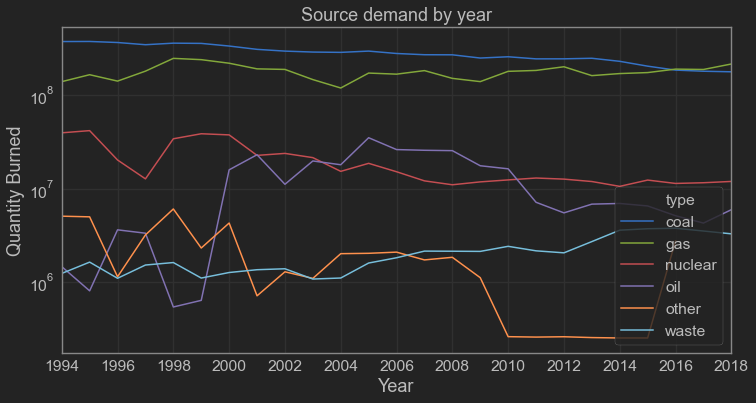

In [133]:
compete = df.groupby(['year', 'type'], as_index=False).agg({'qty_burned':'sum'})
#compete['qty_burned'] = MinMaxScaler().fit_transform(compete['qty_burned'])
fig, ax = plt.subplots(figsize=(12,6))
ax = sns.lineplot(x='year', y='qty_burned', hue='type', data=compete)
ax.set_title('Source demand by year')
ax.set_xlabel('Year')
ax.set_ylabel('Quantity Burned')
ax.set_xlim(1994,2018)
ax.set_yscale('log')
plt.xticks(np.arange(1994, 2018+1, 2))
ax.legend(loc='lower right')
plt.show()

This line plot gives a good view of how these different sources of energy have competed overt the years. Coal seems to have been toping the market, but it's interesting to see how gas has taken the top towards the end of 2016. It is also noteworthy, the huge amount of increase in the demand of oil after 1998 and how it has tried to keep the position stable until 2015.